# Laboratoire 3 : Machines à vecteur de support et réseaux neuronaux
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Alexandre Bleau — BLEA14058906 / David Létinaud  — LETD05129708 / Thomas Lioret   — LIOT20069605|
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2019                                            |
| Groupe                | 1                                                       |
| Numéro du laboratoire | 3                                                       |
| Professeur            | Prof. LOMBAERT                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 18/11/2019                                              |

## Introduction

Au cours de ce troisième laboratoire nous allons étudier deux nouveaux algorithme de classification pour résoudre le problème de classification des galaxies : les réseaux neuronaux et les machines à vecteurs de support (SVM). 
Dans un premier temps, nous allons concevoir un modèle de réseaux neuronaux basé sur le Multi-Layer Perceptron. Nous entrainerons ce modèle afin qu'il puisse classer les galaxies en "smooth" ou "spiral" en utilisant l'ensemble des primitives. Nous utiliserons le module keras de Google tensorflow
Le deuxième modèle d'apprentissage s'appuie sur un modèle d'optimisation convexe dans le cas du SVM. Dans ce cas, nous n'utiliserons qu'une partie des primitives proposées et seront couplées à nos primitives développées lors du premier laboratoire.
Nous étudierons également l'influence des hyperparamètres de ces deux méthodes afin de proposer le modèle le plus optimal dans le cas de notre problème de classification de galaxies.

## Question 1
(grille de correction : Les approches de validations sont présentées et utilisées correctement.)

Dans le cas des réseaux neuronaux, l'utilisation d'une méthode de validation croisée prendrait beaucoup de temps. En effet, il faudrait répéter plusieurs tests avec un nombre "d'epochs" conséquent : ceci serait très chronophage. Nous avons donc décider d'utiliser la méthode de validation hold-out avec 70% de donées d'entrainement et 30% de test.

Concernant la méthode SVM, nous utilisons la méthode ......... (k-fold????)


## Question 2
(La méthode de normalisation des données est décrite et correcte.)

Nous normalisons nos données grâce à la méthode "normalize" de la librairie preprocessing. La normalisation se fait par rapport à la valeur maximale. Nous avons décider de normaliser par rapport aux primitives (axis = 0). Par ailleurs, nous avons remarqué avec nos premier tests que les performances étaient meilleures si l'on normalisait par rapport à la valeur maximale (norm = 'max').

## Question 3
(Le modèle MLP est décrit (structure, nombre de couches). La fonction de coût choisie est mentionnée ainsi que les raisons pour lesquelles elle a été choisie.)

La principale contrainte du modèle MLP est de trouver un compromis entre le temps d'apprentissage et l'accuracy. La première architecture proposée par l'énoncé est de trois couches : 100, 100, 2 (nombre de perceptrons). Nous avons étudié différents cas avec 60 epochs :  
1 - l'influence du nombre de perceptrons avec un nombre de couche fixé.  
2 - l'influence du nombre de couches avec le même nombre de perceptrons par couche.


In [8]:
# Initialisation
# conda install -c conda-forge tensorflow 
from RN_model import *
from SVC import *
from functions import get_data , plot_perf, plot_delay, get_data_GridSearch,plot_Linear_acc,plot_RBF_acc,plot_analyse
import time
import matplotlib.pyplot as plt
#from sklearn.metrics import make_scorer
#from sklearn.metrics import accuracy_score
#from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
#import csv
X_train, X_test, Y_train, Y_test = get_data()

layer_sizes = [100, 100, 2]
epochs = 60
learning_rate = 0.0005
batch_size = 100

dropout = 0.5

# Pour affichage
sub_title = ['loss','acc','f1','val_loss','val_acc', 'val_f1']
x_lab = "epochs"

Voici donc nos résultats avec différentes structures de réseaux de neurones :

1 - a:

In [2]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

nb_perceptrons_range = [[5, 4, 4],[100, 100, 2],[500, 500, 500]]                                                                                                                      

for nb_perceptrons in nb_perceptrons_range:                                                                                                                                                  
    model = RN_model(nb_perceptrons, dropout, learning_rate)                                                                                                                              
    #### Apprentissage                                                                                                                                                             
    start = time.time()                                                                                                                                                            
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test))                                                             

    end = time.time()                                                                                                                                                              
    training_delay_RN.append(end - start)                                                                                                                                          

    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                
    start = time.time()                                                                                                                                                            

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)                                                                                                                           

    end = time.time()                                                                                                                                                              
    predicting_delay_RN.append(end - start)    
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 12800 samples, validate on 3200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/60
12800/12800 [==============================] - 0s 28us/sample - loss: 0.6932 - acc: 0.5165 - f1: 0.6763 - val_loss: 0.6927 - val_acc: 0.5191 - val_f1: 0.6827
Epoch 2/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.6926 - acc: 0.5195 - f1: 0.6811 - val_loss: 0.6924 - val_acc: 0.5191 - val_f1: 0.6814
Epoch 3/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.6925 - acc: 0.5176 - f1: 0.6802 - val_loss: 0.6922 - val_acc: 0.5191 - val_f1: 0.6821
Epoch 4/60
12800/12800 [==============================] - 0s 10us/sample - loss: 0.6823 - acc: 0.5073 - f1: 0.6697 - val_loss: 0.6564 - val_acc: 0.5191 - val_f1: 0.6821
Epoch 5/60
12800/12800 [================

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3973 - acc: 0.8302 - f1: 0.8104 - val_loss: 0.2369 - val_acc: 0.9488 - val_f1: 0.9496
Epoch 32/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3958 - acc: 0.8298 - f1: 0.8085 - val_loss: 0.2326 - val_acc: 0.9519 - val_f1: 0.9520
Epoch 33/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3863 - acc: 0.8363 - f1: 0.8171 - val_loss: 0.2253 - val_acc: 0.9575 - val_f1: 0.9591
Epoch 34/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3911 - acc: 0.8333 - f1: 0.8127 - val_loss: 0.2284 - val_acc: 0.9519 - val_f1: 0.9524
Epoch 35/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4060 - acc: 0.8235 - f1: 0.7996 - val_loss: 0.2559 - val_acc: 0.9350 - val_f1: 0.9336
Epoch 36/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3938 - acc: 0.8312 - f1: 0.8104 - val_loss: 0.2437 - val_acc: 0.9453 - val_f1:

12800/12800 [==============================] - 1s 58us/sample - loss: 0.1138 - acc: 0.9580 - f1: 0.9591 - val_loss: 0.1055 - val_acc: 0.9609 - val_f1: 0.9631
Epoch 20/60
12800/12800 [==============================] - 1s 58us/sample - loss: 0.1114 - acc: 0.9595 - f1: 0.9608 - val_loss: 0.1020 - val_acc: 0.9619 - val_f1: 0.9630
Epoch 21/60
12800/12800 [==============================] - 1s 58us/sample - loss: 0.1098 - acc: 0.9577 - f1: 0.9587 - val_loss: 0.1039 - val_acc: 0.9613 - val_f1: 0.9625
Epoch 22/60
12800/12800 [==============================] - 1s 59us/sample - loss: 0.1100 - acc: 0.9591 - f1: 0.9606 - val_loss: 0.1045 - val_acc: 0.9597 - val_f1: 0.9608
Epoch 23/60
12800/12800 [==============================] - 1s 61us/sample - loss: 0.1100 - acc: 0.9582 - f1: 0.9594 - val_loss: 0.1122 - val_acc: 0.9566 - val_f1: 0.9568
Epoch 24/60
12800/12800 [==============================] - 1s 61us/sample - loss: 0.1077 - acc: 0.9598 - f1: 0.9610 - val_loss: 0.1414 - val_acc: 0.9469 - val_f1:

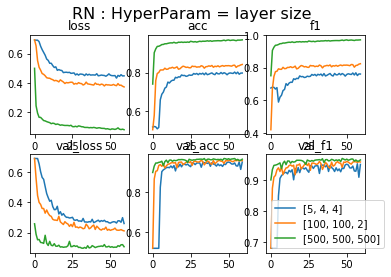

In [3]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

leg = [str(i) for i in nb_perceptrons_range]                                                                                                                                          

titre = "RN : HyperParam = layer size"   

plot_perf(ho, leg, titre ,sub_title)

Nous remarquons qu'avec trois couches, les performances d'accuracy et de f1_score sont meilleurs dans le cas de [500,500,500] (dépassant les 95%). On remarque également que la perte ("loss") est, en quelque sorte, inversement proportionnelle aux f1_score et accuracy dans ce cas. C'est à dire que pour un f1_score et une accuracy plus faible (nombre de perceptrons inférieur) la valeur de perte sera plus importante que les architectures avec plus de perceptrons.


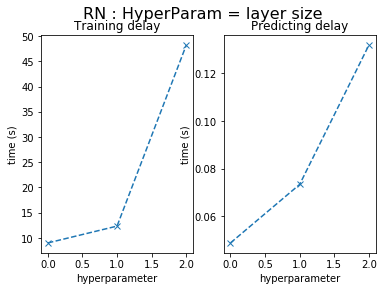

In [4]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)


En revanche, ajouter un nombre de perceptrons par couche important influence grandement le temps d'entrainement et de prediction.


1 - b:

In [10]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

layer_sizes_range = [[100],[100, 100, 2],[100, 100, 100, 100, 100, 2]]

for layer_s in layer_sizes_range:
    model = RN_model(layer_s, dropout, learning_rate)
    #### Apprentissage                                                                                                                                                               
    start = time.time()                                                                                                                   
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test))

    end = time.time()
    training_delay_RN.append(end - start)

    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                  
    start = time.time()

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)

    end = time.time()
    predicting_delay_RN.append(end - start)

Train on 12800 samples, validate on 3200 samples
Epoch 1/60
12800/12800 [==============================] - 1s 49us/sample - loss: 0.6234 - acc: 0.6728 - f1: 0.7001 - val_loss: 0.4902 - val_acc: 0.8391 - val_f1: 0.8390
Epoch 2/60
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4013 - acc: 0.8518 - f1: 0.8558 - val_loss: 0.3231 - val_acc: 0.8778 - val_f1: 0.8792
Epoch 3/60
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3019 - acc: 0.8876 - f1: 0.8905 - val_loss: 0.2578 - val_acc: 0.9103 - val_f1: 0.9156
Epoch 4/60
12800/12800 [==============================] - 0s 16us/sample - loss: 0.2532 - acc: 0.9087 - f1: 0.9110 - val_loss: 0.2169 - val_acc: 0.9237 - val_f1: 0.9281
Epoch 5/60
12800/12800 [==============================] - 0s 22us/sample - loss: 0.2171 - acc: 0.9202 - f1: 0.9224 - val_loss: 0.1956 - val_acc: 0.9216 - val_f1: 0.9213
Epoch 6/60
12800/12800 [==============================] - 0s 18us/sample - loss: 0.1957 - acc: 0.9275 - f1

Epoch 49/60
12800/12800 [==============================] - 0s 13us/sample - loss: 0.1091 - acc: 0.9613 - f1: 0.9624 - val_loss: 0.1123 - val_acc: 0.9544 - val_f1: 0.9546
Epoch 50/60
12800/12800 [==============================] - 0s 13us/sample - loss: 0.1133 - acc: 0.9581 - f1: 0.9597 - val_loss: 0.1062 - val_acc: 0.9591 - val_f1: 0.9603
Epoch 51/60
12800/12800 [==============================] - 0s 13us/sample - loss: 0.1111 - acc: 0.9606 - f1: 0.9618 - val_loss: 0.1046 - val_acc: 0.9600 - val_f1: 0.9608
Epoch 52/60
12800/12800 [==============================] - 0s 13us/sample - loss: 0.1069 - acc: 0.9612 - f1: 0.9626 - val_loss: 0.1056 - val_acc: 0.9622 - val_f1: 0.9633
Epoch 53/60
12800/12800 [==============================] - 0s 13us/sample - loss: 0.1068 - acc: 0.9614 - f1: 0.9627 - val_loss: 0.1040 - val_acc: 0.9603 - val_f1: 0.9623
Epoch 54/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.1098 - acc: 0.9605 - f1: 0.9616 - val_loss: 0.1028 - val_acc: 0.96

Epoch 37/60
12800/12800 [==============================] - 0s 18us/sample - loss: 0.3859 - acc: 0.8422 - f1: 0.8645 - val_loss: 0.2379 - val_acc: 0.9447 - val_f1: 0.9482
Epoch 38/60
12800/12800 [==============================] - 0s 18us/sample - loss: 0.3869 - acc: 0.8382 - f1: 0.8610 - val_loss: 0.2206 - val_acc: 0.9522 - val_f1: 0.9544
Epoch 39/60
12800/12800 [==============================] - 0s 19us/sample - loss: 0.3839 - acc: 0.8444 - f1: 0.8659 - val_loss: 0.2275 - val_acc: 0.9513 - val_f1: 0.9524
Epoch 40/60
12800/12800 [==============================] - 0s 18us/sample - loss: 0.3855 - acc: 0.8418 - f1: 0.8640 - val_loss: 0.2237 - val_acc: 0.9519 - val_f1: 0.9525
Epoch 41/60
12800/12800 [==============================] - 0s 18us/sample - loss: 0.3874 - acc: 0.8393 - f1: 0.8621 - val_loss: 0.2166 - val_acc: 0.9578 - val_f1: 0.9590
Epoch 42/60
12800/12800 [==============================] - 0s 19us/sample - loss: 0.3864 - acc: 0.8430 - f1: 0.8650 - val_loss: 0.2208 - val_acc: 0.95

Epoch 25/60
12800/12800 [==============================] - 0s 28us/sample - loss: 0.5287 - acc: 0.7259 - f1: 0.7857 - val_loss: 0.3444 - val_acc: 0.9372 - val_f1: 0.9408
Epoch 26/60
12800/12800 [==============================] - 0s 27us/sample - loss: 0.5243 - acc: 0.7303 - f1: 0.7884 - val_loss: 0.3826 - val_acc: 0.9259 - val_f1: 0.9325
Epoch 27/60
12800/12800 [==============================] - 0s 27us/sample - loss: 0.5258 - acc: 0.7291 - f1: 0.7882 - val_loss: 0.3278 - val_acc: 0.9425 - val_f1: 0.9454
Epoch 28/60
12800/12800 [==============================] - 0s 27us/sample - loss: 0.5251 - acc: 0.7270 - f1: 0.7870 - val_loss: 0.3137 - val_acc: 0.9438 - val_f1: 0.9465
Epoch 29/60
12800/12800 [==============================] - 0s 28us/sample - loss: 0.5326 - acc: 0.7207 - f1: 0.7824 - val_loss: 0.3718 - val_acc: 0.9281 - val_f1: 0.9347
Epoch 30/60
12800/12800 [==============================] - 0s 26us/sample - loss: 0.5188 - acc: 0.7345 - f1: 0.7916 - val_loss: 0.3437 - val_acc: 0.94

In [7]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

leg = [str(i) for i in layer_sizes_range]                                                                                                                                              

titre = "RN : HyperParam = number of layer"                                                                                                                                         

plot_perf(ho, leg, titre ,sub_title)

NameError: name 'layer_sizes_range' is not defined

Dans notre problème de classification de galaxies, on note que le les valeurs des accuracy et des f1_scores tendent vers les mêmes performances sur les jeux de données de tests qu'il y ait une, trois ou six couches (nb de perceptrons constant par couche). On remarque également que la valeur de perte est moins importante dans le cas où il y le moins de couche. 


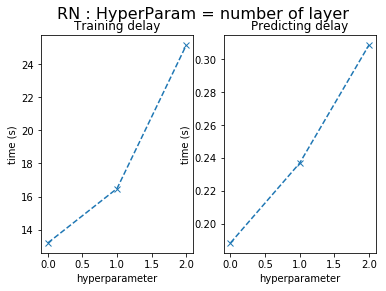

In [12]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)

Ici, nous remarquons que : plus le nombre de couche est important plus le temps d'entrainement et de prediction sont élevés.


In [ ]:

################################## Learning rate                                                                                                                                     

#l_rate_range = [0.00001,0.0005,0.1]                                                                                                                                                          

# for l_rate in l_rate_range:                                                                                                                                                        
#     model = RN_model(layer_sizes, dropout, l_rate)                                                                                                                                 
#     #### Apprentissage                                                                                                                                                             
#     start = time.time()                                                                                                                                                            
#     #model.fit(X_train, Y_train, batch_size = 100, epochs = 60)                                                                                                                    
#     hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test))                                                             
#                                                                                                                                                                                    
#     end = time.time()                                                                                                                                                              
#     training_delay_RN.append(end - start)                                                                                                                                          
#                                                                                                                                                                                    
#     history_obj.append( list(hist_obj.history.values()))                                                                                                                           
#                                                                                                                                                                                    
#     #### Prédiction                                                                                                                                                                
#     start = time.time()                                                                                                                                                            
#                                                                                                                                                                                    
#     Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)                                                                                                                           
#                                                                                                                                                                                    
#     end = time.time()                                                                                                                                                              
#     predicting_delay_RN.append(end - start)   
# 
#   

# Traitement pour affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)
                                                                                                                                      
leg = [str(i) for i in l_rate_range]                                                                                                                                                
                                                                                                                                    
titre = "RN : HyperParam = learning rate"                                                                                                                                           

plot_perf(ho, leg, titre ,sub_title)
plot_delay(training_delay_RN,predicting_delay_RN,titre)

La fonction de coût que nous avons choisie est "Binary Cross-Entropy Loss". En effet, nous avons choisi cette fonction car nos valeurs cibles sont 0 ou 1, soit "smooth" ou "spiral".

## Question 4
(L’analyse est claire et l’équipe démontre une compréhension du phénomène de sur-apprentissage. Il le phénomène est correctement décrit et montré dans le graphique dans la mesure du possible.)


In [5]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

epochs_range = [30,60, 5000]                                                                                                                                            
max_ep = max(epochs_range)                                                                                                                                                         

for ep in epochs_range:                                                                                                                                                            
    model = RN_model(layer_sizes, dropout, learning_rate)                                                                                                                          
    #### Apprentissage                                                                                                                                                             
    start = time.time()                                                                                                                                                            
    #model.fit(X_train, Y_train, batch_size = 100, epochs = 60)                                                                                                                    
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = ep, validation_data=(X_test, Y_test))                                                                 

    end = time.time()                                                                                                                                                              
    training_delay_RN.append(end - start)                                                                                                                                          

    ho_tmp = list(hist_obj.history.values())                                                                                                                                       
    ho_tmp = [i + [np.nan for _ in range(max_ep-ep)] for i in ho_tmp ]                                                                                                             
    history_obj.append(ho_tmp)
    #### Prédiction                                                                                                                                                                
    start = time.time()                                                                                                                                                            

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)                                                                                                                           

    end = time.time()                                                                                                                                                              
    predicting_delay_RN.append(end - start) 


Train on 12800 samples, validate on 3200 samples
Epoch 1/30
12800/12800 [==============================] - 0s 35us/sample - loss: 0.6914 - acc: 0.5196 - f1: 0.5394 - val_loss: 0.6674 - val_acc: 0.6288 - val_f1: 0.7314
Epoch 2/30
12800/12800 [==============================] - 0s 16us/sample - loss: 0.6181 - acc: 0.6126 - f1: 0.6093 - val_loss: 0.4916 - val_acc: 0.8550 - val_f1: 0.8533
Epoch 3/30
12800/12800 [==============================] - 0s 16us/sample - loss: 0.5316 - acc: 0.6757 - f1: 0.5877 - val_loss: 0.3570 - val_acc: 0.9041 - val_f1: 0.9079
Epoch 4/30
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4955 - acc: 0.6856 - f1: 0.5981 - val_loss: 0.3395 - val_acc: 0.8966 - val_f1: 0.8922
Epoch 5/30
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4658 - acc: 0.6995 - f1: 0.6151 - val_loss: 0.2713 - val_acc: 0.9325 - val_f1: 0.9354
Epoch 6/30
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4485 - acc: 0.7016 - f1

Epoch 19/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3978 - acc: 0.8338 - f1: 0.8147 - val_loss: 0.2567 - val_acc: 0.9519 - val_f1: 0.9532
Epoch 20/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4058 - acc: 0.8241 - f1: 0.8023 - val_loss: 0.2704 - val_acc: 0.9378 - val_f1: 0.9363
Epoch 21/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3990 - acc: 0.8291 - f1: 0.8078 - val_loss: 0.2408 - val_acc: 0.9569 - val_f1: 0.9584
Epoch 22/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4000 - acc: 0.8280 - f1: 0.8068 - val_loss: 0.2412 - val_acc: 0.9544 - val_f1: 0.9552
Epoch 23/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3924 - acc: 0.8316 - f1: 0.8107 - val_loss: 0.2397 - val_acc: 0.9544 - val_f1: 0.9554
Epoch 24/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4002 - acc: 0.8291 - f1: 0.8078 - val_loss: 0.2452 - val_acc: 0.95

Epoch 7/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4668 - acc: 0.8155 - f1: 0.8425 - val_loss: 0.3501 - val_acc: 0.9362 - val_f1: 0.9390
Epoch 8/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4544 - acc: 0.8248 - f1: 0.8497 - val_loss: 0.3380 - val_acc: 0.9344 - val_f1: 0.9373
Epoch 9/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4514 - acc: 0.8207 - f1: 0.8469 - val_loss: 0.3306 - val_acc: 0.9362 - val_f1: 0.9384
Epoch 10/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4338 - acc: 0.8320 - f1: 0.8548 - val_loss: 0.3279 - val_acc: 0.9375 - val_f1: 0.9416
Epoch 11/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4344 - acc: 0.8300 - f1: 0.8540 - val_loss: 0.3064 - val_acc: 0.9394 - val_f1: 0.9415
Epoch 12/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4189 - acc: 0.8359 - f1: 0.8589 - val_loss: 0.3015 - val_

Epoch 55/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3771 - acc: 0.8459 - f1: 0.8675 - val_loss: 0.2483 - val_acc: 0.9353 - val_f1: 0.9407
Epoch 56/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3681 - acc: 0.8505 - f1: 0.8710 - val_loss: 0.2095 - val_acc: 0.9525 - val_f1: 0.9552
Epoch 57/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3770 - acc: 0.8467 - f1: 0.8675 - val_loss: 0.2199 - val_acc: 0.9472 - val_f1: 0.9505
Epoch 58/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3778 - acc: 0.8461 - f1: 0.8675 - val_loss: 0.2065 - val_acc: 0.9578 - val_f1: 0.9591
Epoch 59/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3802 - acc: 0.8440 - f1: 0.8660 - val_loss: 0.2077 - val_acc: 0.9572 - val_f1: 0.9580
Epoch 60/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3676 - acc: 0.8542 - f1: 0.8736 - val_loss: 0.2079 - v

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3609 - acc: 0.8530 - f1: 0.8732 - val_loss: 0.2022 - val_acc: 0.9547 - val_f1: 0.9576
Epoch 150/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3676 - acc: 0.8499 - f1: 0.8709 - val_loss: 0.2003 - val_acc: 0.9628 - val_f1: 0.9641
Epoch 151/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3573 - acc: 0.8559 - f1: 0.8760 - val_loss: 0.2017 - val_acc: 0.9547 - val_f1: 0.9566
Epoch 152/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3598 - acc: 0.8558 - f1: 0.8748 - val_loss: 0.1992 - val_acc: 0.9634 - val_f1: 0.9651
Epoch 153/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3551 - acc: 0.8569 - f1: 0.8764 - val_loss: 0.1945 - val_acc: 0.9628 - val_f1: 0.9643
Epoch 154/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3613 - acc: 0.8530 - f1: 0.8730 - val_loss: 0.1915 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3627 - acc: 0.8514 - f1: 0.8723 - val_loss: 0.2042 - val_acc: 0.9563 - val_f1: 0.9589
Epoch 244/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3547 - acc: 0.8577 - f1: 0.8769 - val_loss: 0.1992 - val_acc: 0.9613 - val_f1: 0.9639
Epoch 245/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3460 - acc: 0.8609 - f1: 0.8797 - val_loss: 0.2264 - val_acc: 0.9422 - val_f1: 0.9460
Epoch 246/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3501 - acc: 0.8594 - f1: 0.8785 - val_loss: 0.1938 - val_acc: 0.9653 - val_f1: 0.9667
Epoch 247/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3482 - acc: 0.8616 - f1: 0.8795 - val_loss: 0.1965 - val_acc: 0.9650 - val_f1: 0.9659
Epoch 248/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3535 - acc: 0.8582 - f1: 0.8774 - val_loss: 0.2144 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3594 - acc: 0.8540 - f1: 0.8741 - val_loss: 0.2015 - val_acc: 0.9619 - val_f1: 0.9639
Epoch 338/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3537 - acc: 0.8590 - f1: 0.8787 - val_loss: 0.1952 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 339/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3483 - acc: 0.8598 - f1: 0.8787 - val_loss: 0.2082 - val_acc: 0.9644 - val_f1: 0.9654
Epoch 340/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3452 - acc: 0.8619 - f1: 0.8802 - val_loss: 0.2034 - val_acc: 0.9631 - val_f1: 0.9644
Epoch 341/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3522 - acc: 0.8548 - f1: 0.8751 - val_loss: 0.2038 - val_acc: 0.9619 - val_f1: 0.9634
Epoch 342/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3390 - acc: 0.8651 - f1: 0.8831 - val_loss: 0.1966 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3483 - acc: 0.8589 - f1: 0.8786 - val_loss: 0.1964 - val_acc: 0.9641 - val_f1: 0.9652
Epoch 432/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3432 - acc: 0.8623 - f1: 0.8805 - val_loss: 0.2115 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 433/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3513 - acc: 0.8579 - f1: 0.8771 - val_loss: 0.2042 - val_acc: 0.9634 - val_f1: 0.9652
Epoch 434/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3441 - acc: 0.8627 - f1: 0.8808 - val_loss: 0.2059 - val_acc: 0.9641 - val_f1: 0.9653
Epoch 435/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3513 - acc: 0.8587 - f1: 0.8776 - val_loss: 0.2047 - val_acc: 0.9622 - val_f1: 0.9638
Epoch 436/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3515 - acc: 0.8580 - f1: 0.8772 - val_loss: 0.2024 - val_acc: 0

12800/12800 [==============================] - 0s 16us/sample - loss: 0.3492 - acc: 0.8598 - f1: 0.8789 - val_loss: 0.2025 - val_acc: 0.9656 - val_f1: 0.9670
Epoch 526/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3598 - acc: 0.8547 - f1: 0.8747 - val_loss: 0.2074 - val_acc: 0.9641 - val_f1: 0.9657
Epoch 527/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3442 - acc: 0.8622 - f1: 0.8811 - val_loss: 0.2019 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 528/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3432 - acc: 0.8630 - f1: 0.8817 - val_loss: 0.2049 - val_acc: 0.9669 - val_f1: 0.9680
Epoch 529/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3437 - acc: 0.8624 - f1: 0.8813 - val_loss: 0.2188 - val_acc: 0.9506 - val_f1: 0.9535
Epoch 530/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3442 - acc: 0.8618 - f1: 0.8807 - val_loss: 0.2052 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3417 - acc: 0.8636 - f1: 0.8821 - val_loss: 0.2054 - val_acc: 0.9584 - val_f1: 0.9605
Epoch 620/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3475 - acc: 0.8599 - f1: 0.8795 - val_loss: 0.2136 - val_acc: 0.9581 - val_f1: 0.9607
Epoch 621/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3454 - acc: 0.8612 - f1: 0.8800 - val_loss: 0.2098 - val_acc: 0.9631 - val_f1: 0.9644
Epoch 622/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3390 - acc: 0.8650 - f1: 0.8830 - val_loss: 0.2060 - val_acc: 0.9656 - val_f1: 0.9669
Epoch 623/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3469 - acc: 0.8598 - f1: 0.8791 - val_loss: 0.2014 - val_acc: 0.9653 - val_f1: 0.9668
Epoch 624/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3376 - acc: 0.8655 - f1: 0.8835 - val_loss: 0.2140 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3423 - acc: 0.8632 - f1: 0.8812 - val_loss: 0.2132 - val_acc: 0.9603 - val_f1: 0.9619
Epoch 714/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3382 - acc: 0.8645 - f1: 0.8829 - val_loss: 0.2092 - val_acc: 0.9663 - val_f1: 0.9677
Epoch 715/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3427 - acc: 0.8612 - f1: 0.8800 - val_loss: 0.2099 - val_acc: 0.9578 - val_f1: 0.9607
Epoch 716/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3488 - acc: 0.8598 - f1: 0.8794 - val_loss: 0.2114 - val_acc: 0.9600 - val_f1: 0.9622
Epoch 717/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3441 - acc: 0.8616 - f1: 0.8807 - val_loss: 0.2126 - val_acc: 0.9616 - val_f1: 0.9631
Epoch 718/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3468 - acc: 0.8594 - f1: 0.8787 - val_loss: 0.2161 - val_acc: 0

Epoch 760/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3415 - acc: 0.8642 - f1: 0.8824 - val_loss: 0.2088 - val_acc: 0.9619 - val_f1: 0.9638
Epoch 761/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3380 - acc: 0.8659 - f1: 0.8840 - val_loss: 0.2097 - val_acc: 0.9631 - val_f1: 0.9646
Epoch 762/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3370 - acc: 0.8660 - f1: 0.8841 - val_loss: 0.2050 - val_acc: 0.9638 - val_f1: 0.9654
Epoch 763/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3415 - acc: 0.8625 - f1: 0.8814 - val_loss: 0.2122 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 764/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3384 - acc: 0.8647 - f1: 0.8832 - val_loss: 0.2053 - val_acc: 0.9650 - val_f1: 0.9664
Epoch 765/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3384 - acc: 0.8645 - f1: 0.8829 - val_loss: 0.20

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3477 - acc: 0.8590 - f1: 0.8788 - val_loss: 0.2070 - val_acc: 0.9644 - val_f1: 0.9654
Epoch 808/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3416 - acc: 0.8630 - f1: 0.8817 - val_loss: 0.2040 - val_acc: 0.9672 - val_f1: 0.9691
Epoch 809/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3408 - acc: 0.8627 - f1: 0.8813 - val_loss: 0.2304 - val_acc: 0.9616 - val_f1: 0.9626
Epoch 810/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3375 - acc: 0.8659 - f1: 0.8838 - val_loss: 0.2091 - val_acc: 0.9609 - val_f1: 0.9625
Epoch 811/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3382 - acc: 0.8640 - f1: 0.8822 - val_loss: 0.2075 - val_acc: 0.9641 - val_f1: 0.9655
Epoch 812/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3390 - acc: 0.8655 - f1: 0.8831 - val_loss: 0.2062 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3448 - acc: 0.8607 - f1: 0.8799 - val_loss: 0.2154 - val_acc: 0.9669 - val_f1: 0.9683
Epoch 902/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3382 - acc: 0.8652 - f1: 0.8833 - val_loss: 0.2099 - val_acc: 0.9666 - val_f1: 0.9678
Epoch 903/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3315 - acc: 0.8680 - f1: 0.8858 - val_loss: 0.2529 - val_acc: 0.9613 - val_f1: 0.9617
Epoch 904/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3361 - acc: 0.8667 - f1: 0.8842 - val_loss: 0.2133 - val_acc: 0.9659 - val_f1: 0.9670
Epoch 905/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3440 - acc: 0.8637 - f1: 0.8818 - val_loss: 0.2169 - val_acc: 0.9650 - val_f1: 0.9652
Epoch 906/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3362 - acc: 0.8645 - f1: 0.8829 - val_loss: 0.2198 - val_acc: 0

12800/12800 [==============================] - 0s 16us/sample - loss: 0.3374 - acc: 0.8645 - f1: 0.8834 - val_loss: 0.2136 - val_acc: 0.9659 - val_f1: 0.9671
Epoch 996/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3429 - acc: 0.8616 - f1: 0.8808 - val_loss: 0.2107 - val_acc: 0.9659 - val_f1: 0.9679
Epoch 997/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3310 - acc: 0.8673 - f1: 0.8848 - val_loss: 0.2336 - val_acc: 0.9675 - val_f1: 0.9686
Epoch 998/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3408 - acc: 0.8641 - f1: 0.8826 - val_loss: 0.2525 - val_acc: 0.9522 - val_f1: 0.9533
Epoch 999/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3489 - acc: 0.8580 - f1: 0.8781 - val_loss: 0.2206 - val_acc: 0.9653 - val_f1: 0.9667
Epoch 1000/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3279 - acc: 0.8713 - f1: 0.8882 - val_loss: 0.2112 - val_acc: 

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3405 - acc: 0.8632 - f1: 0.8819 - val_loss: 0.2302 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 1090/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3339 - acc: 0.8660 - f1: 0.8842 - val_loss: 0.2252 - val_acc: 0.9653 - val_f1: 0.9669
Epoch 1091/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3376 - acc: 0.8646 - f1: 0.8833 - val_loss: 0.2329 - val_acc: 0.9622 - val_f1: 0.9633
Epoch 1092/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3464 - acc: 0.8599 - f1: 0.8794 - val_loss: 0.2165 - val_acc: 0.9609 - val_f1: 0.9624
Epoch 1093/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3398 - acc: 0.8634 - f1: 0.8819 - val_loss: 0.2128 - val_acc: 0.9597 - val_f1: 0.9617
Epoch 1094/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3297 - acc: 0.8686 - f1: 0.8864 - val_loss: 0.2141 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3421 - acc: 0.8620 - f1: 0.8807 - val_loss: 0.2178 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 1184/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8677 - f1: 0.8852 - val_loss: 0.2361 - val_acc: 0.9653 - val_f1: 0.9662
Epoch 1185/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3249 - acc: 0.8728 - f1: 0.8893 - val_loss: 0.2366 - val_acc: 0.9394 - val_f1: 0.9437
Epoch 1186/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3496 - acc: 0.8601 - f1: 0.8791 - val_loss: 0.2057 - val_acc: 0.9638 - val_f1: 0.9656
Epoch 1187/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3437 - acc: 0.8620 - f1: 0.8809 - val_loss: 0.2121 - val_acc: 0.9584 - val_f1: 0.9605
Epoch 1188/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3383 - acc: 0.8649 - f1: 0.8831 - val_loss: 0.2154 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3312 - acc: 0.8680 - f1: 0.8858 - val_loss: 0.2158 - val_acc: 0.9653 - val_f1: 0.9668
Epoch 1278/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3393 - acc: 0.8639 - f1: 0.8824 - val_loss: 0.2336 - val_acc: 0.9641 - val_f1: 0.9648
Epoch 1279/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3412 - acc: 0.8639 - f1: 0.8820 - val_loss: 0.2163 - val_acc: 0.9581 - val_f1: 0.9608
Epoch 1280/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3307 - acc: 0.8694 - f1: 0.8863 - val_loss: 0.2039 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 1281/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3370 - acc: 0.8648 - f1: 0.8836 - val_loss: 0.2183 - val_acc: 0.9653 - val_f1: 0.9671
Epoch 1282/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3396 - acc: 0.8635 - f1: 0.8825 - val_loss: 0.2298 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3313 - acc: 0.8686 - f1: 0.8861 - val_loss: 0.2209 - val_acc: 0.9572 - val_f1: 0.9589
Epoch 1372/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8681 - f1: 0.8858 - val_loss: 0.2198 - val_acc: 0.9622 - val_f1: 0.9639
Epoch 1373/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3384 - acc: 0.8645 - f1: 0.8830 - val_loss: 0.2141 - val_acc: 0.9594 - val_f1: 0.9619
Epoch 1374/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3340 - acc: 0.8670 - f1: 0.8854 - val_loss: 0.2241 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 1375/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3380 - acc: 0.8656 - f1: 0.8842 - val_loss: 0.2109 - val_acc: 0.9594 - val_f1: 0.9613
Epoch 1376/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3353 - acc: 0.8671 - f1: 0.8848 - val_loss: 0.2282 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3336 - acc: 0.8669 - f1: 0.8849 - val_loss: 0.2183 - val_acc: 0.9669 - val_f1: 0.9685
Epoch 1466/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3393 - acc: 0.8655 - f1: 0.8834 - val_loss: 0.2232 - val_acc: 0.9663 - val_f1: 0.9670
Epoch 1467/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3380 - acc: 0.8641 - f1: 0.8831 - val_loss: 0.2172 - val_acc: 0.9681 - val_f1: 0.9695
Epoch 1468/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3315 - acc: 0.8683 - f1: 0.8858 - val_loss: 0.2299 - val_acc: 0.9638 - val_f1: 0.9656
Epoch 1469/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3368 - acc: 0.8648 - f1: 0.8835 - val_loss: 0.2143 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 1470/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3283 - acc: 0.8708 - f1: 0.8879 - val_loss: 0.2248 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3361 - acc: 0.8659 - f1: 0.8841 - val_loss: 0.2175 - val_acc: 0.9594 - val_f1: 0.9615
Epoch 1560/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3486 - acc: 0.8585 - f1: 0.8783 - val_loss: 0.2077 - val_acc: 0.9628 - val_f1: 0.9649
Epoch 1561/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3353 - acc: 0.8672 - f1: 0.8854 - val_loss: 0.2395 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 1562/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3308 - acc: 0.8694 - f1: 0.8864 - val_loss: 0.2416 - val_acc: 0.9638 - val_f1: 0.9642
Epoch 1563/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3321 - acc: 0.8677 - f1: 0.8860 - val_loss: 0.2112 - val_acc: 0.9669 - val_f1: 0.9685
Epoch 1564/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3314 - acc: 0.8673 - f1: 0.8856 - val_loss: 0.2387 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3340 - acc: 0.8659 - f1: 0.8839 - val_loss: 0.2224 - val_acc: 0.9628 - val_f1: 0.9648
Epoch 1654/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3456 - acc: 0.8613 - f1: 0.8807 - val_loss: 0.2118 - val_acc: 0.9656 - val_f1: 0.9672
Epoch 1655/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3267 - acc: 0.8717 - f1: 0.8885 - val_loss: 0.2268 - val_acc: 0.9675 - val_f1: 0.9690
Epoch 1656/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3412 - acc: 0.8631 - f1: 0.8820 - val_loss: 0.2256 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 1657/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3304 - acc: 0.8687 - f1: 0.8864 - val_loss: 0.2236 - val_acc: 0.9656 - val_f1: 0.9674
Epoch 1658/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3364 - acc: 0.8662 - f1: 0.8848 - val_loss: 0.2204 - val_a

Epoch 1747/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3386 - acc: 0.8640 - f1: 0.8827 - val_loss: 0.2190 - val_acc: 0.9641 - val_f1: 0.9654
Epoch 1748/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3300 - acc: 0.8694 - f1: 0.8868 - val_loss: 0.2366 - val_acc: 0.9603 - val_f1: 0.9619
Epoch 1749/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8676 - f1: 0.8855 - val_loss: 0.2214 - val_acc: 0.9669 - val_f1: 0.9675
Epoch 1750/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3397 - acc: 0.8631 - f1: 0.8824 - val_loss: 0.2145 - val_acc: 0.9656 - val_f1: 0.9674
Epoch 1751/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3422 - acc: 0.8627 - f1: 0.8814 - val_loss: 0.2580 - val_acc: 0.9638 - val_f1: 0.9647
Epoch 1752/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3276 - acc: 0.8723 - f1: 0.8888 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3326 - acc: 0.8679 - f1: 0.8853 - val_loss: 0.2136 - val_acc: 0.9644 - val_f1: 0.9657
Epoch 1795/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8682 - f1: 0.8861 - val_loss: 0.2301 - val_acc: 0.9672 - val_f1: 0.9683
Epoch 1796/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3348 - acc: 0.8662 - f1: 0.8843 - val_loss: 0.2234 - val_acc: 0.9619 - val_f1: 0.9628
Epoch 1797/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3276 - acc: 0.8709 - f1: 0.8881 - val_loss: 0.2291 - val_acc: 0.9675 - val_f1: 0.9681
Epoch 1798/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3235 - acc: 0.8725 - f1: 0.8891 - val_loss: 0.2343 - val_acc: 0.9666 - val_f1: 0.9678
Epoch 1799/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3305 - acc: 0.8678 - f1: 0.8857 - val_loss: 0.2192 - val_a

Epoch 1888/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3336 - acc: 0.8677 - f1: 0.8856 - val_loss: 0.2498 - val_acc: 0.9616 - val_f1: 0.9624
Epoch 1889/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3353 - acc: 0.8662 - f1: 0.8847 - val_loss: 0.2320 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 1890/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3261 - acc: 0.8716 - f1: 0.8888 - val_loss: 0.2290 - val_acc: 0.9650 - val_f1: 0.9664
Epoch 1891/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3357 - acc: 0.8659 - f1: 0.8844 - val_loss: 0.2467 - val_acc: 0.9663 - val_f1: 0.9670
Epoch 1892/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3329 - acc: 0.8676 - f1: 0.8854 - val_loss: 0.2222 - val_acc: 0.9688 - val_f1: 0.9699
Epoch 1893/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3313 - acc: 0.8673 - f1: 0.8849 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3334 - acc: 0.8667 - f1: 0.8847 - val_loss: 0.2241 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 1936/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3341 - acc: 0.8680 - f1: 0.8858 - val_loss: 0.2220 - val_acc: 0.9616 - val_f1: 0.9632
Epoch 1937/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3284 - acc: 0.8720 - f1: 0.8887 - val_loss: 0.2213 - val_acc: 0.9669 - val_f1: 0.9678
Epoch 1938/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3225 - acc: 0.8736 - f1: 0.8903 - val_loss: 0.2243 - val_acc: 0.9650 - val_f1: 0.9669
Epoch 1939/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3383 - acc: 0.8641 - f1: 0.8825 - val_loss: 0.2199 - val_acc: 0.9647 - val_f1: 0.9655
Epoch 1940/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8694 - f1: 0.8870 - val_loss: 0.2167 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3377 - acc: 0.8647 - f1: 0.8835 - val_loss: 0.2374 - val_acc: 0.9653 - val_f1: 0.9663
Epoch 2030/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3393 - acc: 0.8647 - f1: 0.8834 - val_loss: 0.2297 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 2031/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3401 - acc: 0.8648 - f1: 0.8833 - val_loss: 0.2173 - val_acc: 0.9634 - val_f1: 0.9649
Epoch 2032/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3219 - acc: 0.8746 - f1: 0.8910 - val_loss: 0.2166 - val_acc: 0.9644 - val_f1: 0.9661
Epoch 2033/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3250 - acc: 0.8714 - f1: 0.8887 - val_loss: 0.2293 - val_acc: 0.9653 - val_f1: 0.9666
Epoch 2034/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3160 - acc: 0.8775 - f1: 0.8932 - val_loss: 0.2545 - val_a

Epoch 2076/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3251 - acc: 0.8715 - f1: 0.8880 - val_loss: 0.2219 - val_acc: 0.9650 - val_f1: 0.9664
Epoch 2077/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8680 - f1: 0.8861 - val_loss: 0.2246 - val_acc: 0.9650 - val_f1: 0.9660
Epoch 2078/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3330 - acc: 0.8673 - f1: 0.8850 - val_loss: 0.2230 - val_acc: 0.9666 - val_f1: 0.9675
Epoch 2079/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3301 - acc: 0.8687 - f1: 0.8867 - val_loss: 0.2268 - val_acc: 0.9678 - val_f1: 0.9690
Epoch 2080/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3258 - acc: 0.8711 - f1: 0.8886 - val_loss: 0.2286 - val_acc: 0.9663 - val_f1: 0.9677
Epoch 2081/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8686 - f1: 0.8865 - val_loss

Epoch 2123/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3319 - acc: 0.8667 - f1: 0.8847 - val_loss: 0.2575 - val_acc: 0.9647 - val_f1: 0.9658
Epoch 2124/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3417 - acc: 0.8639 - f1: 0.8828 - val_loss: 0.2187 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 2125/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3275 - acc: 0.8705 - f1: 0.8879 - val_loss: 0.2218 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 2126/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3332 - acc: 0.8666 - f1: 0.8850 - val_loss: 0.2306 - val_acc: 0.9625 - val_f1: 0.9637
Epoch 2127/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3337 - acc: 0.8655 - f1: 0.8838 - val_loss: 0.2328 - val_acc: 0.9600 - val_f1: 0.9618
Epoch 2128/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3473 - acc: 0.8612 - f1: 0.8805 - val_loss

Epoch 2170/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3298 - acc: 0.8676 - f1: 0.8854 - val_loss: 0.2279 - val_acc: 0.9647 - val_f1: 0.9655
Epoch 2171/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3165 - acc: 0.8767 - f1: 0.8927 - val_loss: 0.2359 - val_acc: 0.9663 - val_f1: 0.9674
Epoch 2172/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3333 - acc: 0.8667 - f1: 0.8851 - val_loss: 0.2320 - val_acc: 0.9631 - val_f1: 0.9645
Epoch 2173/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3265 - acc: 0.8722 - f1: 0.8891 - val_loss: 0.2422 - val_acc: 0.9694 - val_f1: 0.9704
Epoch 2174/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3273 - acc: 0.8692 - f1: 0.8868 - val_loss: 0.2309 - val_acc: 0.9619 - val_f1: 0.9635
Epoch 2175/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3291 - acc: 0.8688 - f1: 0.8861 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8695 - f1: 0.8870 - val_loss: 0.2239 - val_acc: 0.9647 - val_f1: 0.9660
Epoch 2218/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3280 - acc: 0.8714 - f1: 0.8881 - val_loss: 0.2530 - val_acc: 0.9653 - val_f1: 0.9666
Epoch 2219/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3333 - acc: 0.8673 - f1: 0.8853 - val_loss: 0.2181 - val_acc: 0.9666 - val_f1: 0.9676
Epoch 2220/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3377 - acc: 0.8640 - f1: 0.8828 - val_loss: 0.2182 - val_acc: 0.9628 - val_f1: 0.9640
Epoch 2221/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3386 - acc: 0.8641 - f1: 0.8828 - val_loss: 0.2200 - val_acc: 0.9625 - val_f1: 0.9641
Epoch 2222/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3320 - acc: 0.8670 - f1: 0.8847 - val_loss: 0.2411 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3395 - acc: 0.8630 - f1: 0.8819 - val_loss: 0.2150 - val_acc: 0.9641 - val_f1: 0.9650
Epoch 2312/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3245 - acc: 0.8723 - f1: 0.8889 - val_loss: 0.2598 - val_acc: 0.9631 - val_f1: 0.9643
Epoch 2313/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3248 - acc: 0.8712 - f1: 0.8886 - val_loss: 0.2259 - val_acc: 0.9619 - val_f1: 0.9638
Epoch 2314/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3321 - acc: 0.8670 - f1: 0.8853 - val_loss: 0.2287 - val_acc: 0.9653 - val_f1: 0.9667
Epoch 2315/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3382 - acc: 0.8645 - f1: 0.8831 - val_loss: 0.2204 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 2316/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3352 - acc: 0.8666 - f1: 0.8844 - val_loss: 0.2365 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3210 - acc: 0.8737 - f1: 0.8901 - val_loss: 0.2259 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 2406/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3316 - acc: 0.8677 - f1: 0.8855 - val_loss: 0.2300 - val_acc: 0.9609 - val_f1: 0.9630
Epoch 2407/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3266 - acc: 0.8714 - f1: 0.8884 - val_loss: 0.2496 - val_acc: 0.9644 - val_f1: 0.9652
Epoch 2408/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3258 - acc: 0.8712 - f1: 0.8883 - val_loss: 0.2285 - val_acc: 0.9647 - val_f1: 0.9658
Epoch 2409/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8702 - f1: 0.8877 - val_loss: 0.2459 - val_acc: 0.9644 - val_f1: 0.9652
Epoch 2410/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3283 - acc: 0.8687 - f1: 0.8869 - val_loss: 0.2270 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3355 - acc: 0.8665 - f1: 0.8848 - val_loss: 0.2169 - val_acc: 0.9619 - val_f1: 0.9642
Epoch 2500/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3342 - acc: 0.8680 - f1: 0.8863 - val_loss: 0.2415 - val_acc: 0.9656 - val_f1: 0.9669
Epoch 2501/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8727 - f1: 0.8897 - val_loss: 0.2130 - val_acc: 0.9653 - val_f1: 0.9671
Epoch 2502/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3366 - acc: 0.8642 - f1: 0.8829 - val_loss: 0.2279 - val_acc: 0.9638 - val_f1: 0.9654
Epoch 2503/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3261 - acc: 0.8715 - f1: 0.8885 - val_loss: 0.2311 - val_acc: 0.9656 - val_f1: 0.9670
Epoch 2504/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3319 - acc: 0.8666 - f1: 0.8845 - val_loss: 0.2351 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3264 - acc: 0.8723 - f1: 0.8886 - val_loss: 0.2276 - val_acc: 0.9650 - val_f1: 0.9660
Epoch 2594/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3235 - acc: 0.8730 - f1: 0.8899 - val_loss: 0.2243 - val_acc: 0.9647 - val_f1: 0.9662
Epoch 2595/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3255 - acc: 0.8719 - f1: 0.8884 - val_loss: 0.2378 - val_acc: 0.9634 - val_f1: 0.9645
Epoch 2596/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3299 - acc: 0.8696 - f1: 0.8869 - val_loss: 0.2260 - val_acc: 0.9672 - val_f1: 0.9677
Epoch 2597/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3284 - acc: 0.8691 - f1: 0.8868 - val_loss: 0.2398 - val_acc: 0.9650 - val_f1: 0.9664
Epoch 2598/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3199 - acc: 0.8752 - f1: 0.8918 - val_loss: 0.2572 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8689 - f1: 0.8863 - val_loss: 0.2531 - val_acc: 0.9659 - val_f1: 0.9667
Epoch 2688/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3215 - acc: 0.8730 - f1: 0.8898 - val_loss: 0.2293 - val_acc: 0.9672 - val_f1: 0.9686
Epoch 2689/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3261 - acc: 0.8710 - f1: 0.8883 - val_loss: 0.2184 - val_acc: 0.9616 - val_f1: 0.9637
Epoch 2690/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3313 - acc: 0.8683 - f1: 0.8864 - val_loss: 0.2368 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 2691/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3274 - acc: 0.8694 - f1: 0.8874 - val_loss: 0.2384 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 2692/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3262 - acc: 0.8709 - f1: 0.8884 - val_loss: 0.2394 - val_a

Epoch 2734/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3170 - acc: 0.8766 - f1: 0.8923 - val_loss: 0.2609 - val_acc: 0.9650 - val_f1: 0.9658
Epoch 2735/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3259 - acc: 0.8709 - f1: 0.8882 - val_loss: 0.2309 - val_acc: 0.9675 - val_f1: 0.9685
Epoch 2736/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8723 - f1: 0.8886 - val_loss: 0.2255 - val_acc: 0.9591 - val_f1: 0.9612
Epoch 2737/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3406 - acc: 0.8643 - f1: 0.8832 - val_loss: 0.2193 - val_acc: 0.9613 - val_f1: 0.9629
Epoch 2738/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3367 - acc: 0.8649 - f1: 0.8836 - val_loss: 0.2478 - val_acc: 0.9669 - val_f1: 0.9682
Epoch 2739/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3255 - acc: 0.8719 - f1: 0.8887 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3328 - acc: 0.8673 - f1: 0.8847 - val_loss: 0.2284 - val_acc: 0.9644 - val_f1: 0.9652
Epoch 2782/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8698 - f1: 0.8872 - val_loss: 0.2271 - val_acc: 0.9581 - val_f1: 0.9601
Epoch 2783/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8722 - f1: 0.8892 - val_loss: 0.2650 - val_acc: 0.9634 - val_f1: 0.9644
Epoch 2784/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3228 - acc: 0.8745 - f1: 0.8912 - val_loss: 0.2611 - val_acc: 0.9631 - val_f1: 0.9642
Epoch 2785/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3329 - acc: 0.8682 - f1: 0.8858 - val_loss: 0.2269 - val_acc: 0.9578 - val_f1: 0.9599
Epoch 2786/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3345 - acc: 0.8666 - f1: 0.8850 - val_loss: 0.2258 - val_a

12800/12800 [==============================] - 0s 16us/sample - loss: 0.3265 - acc: 0.8705 - f1: 0.8877 - val_loss: 0.2261 - val_acc: 0.9634 - val_f1: 0.9650
Epoch 2876/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3343 - acc: 0.8670 - f1: 0.8852 - val_loss: 0.2485 - val_acc: 0.9647 - val_f1: 0.9657
Epoch 2877/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3326 - acc: 0.8682 - f1: 0.8860 - val_loss: 0.2329 - val_acc: 0.9634 - val_f1: 0.9648
Epoch 2878/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3422 - acc: 0.8618 - f1: 0.8808 - val_loss: 0.2188 - val_acc: 0.9569 - val_f1: 0.9590
Epoch 2879/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8692 - f1: 0.8872 - val_loss: 0.2458 - val_acc: 0.9653 - val_f1: 0.9663
Epoch 2880/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3274 - acc: 0.8706 - f1: 0.8883 - val_loss: 0.2534 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3281 - acc: 0.8702 - f1: 0.8876 - val_loss: 0.2427 - val_acc: 0.9531 - val_f1: 0.9555
Epoch 2970/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3393 - acc: 0.8650 - f1: 0.8836 - val_loss: 0.2331 - val_acc: 0.9631 - val_f1: 0.9638
Epoch 2971/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3336 - acc: 0.8678 - f1: 0.8855 - val_loss: 0.2598 - val_acc: 0.9666 - val_f1: 0.9672
Epoch 2972/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3275 - acc: 0.8709 - f1: 0.8882 - val_loss: 0.2481 - val_acc: 0.9631 - val_f1: 0.9639
Epoch 2973/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3273 - acc: 0.8711 - f1: 0.8886 - val_loss: 0.2511 - val_acc: 0.9650 - val_f1: 0.9665
Epoch 2974/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3267 - acc: 0.8703 - f1: 0.8879 - val_loss: 0.2635 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3368 - acc: 0.8662 - f1: 0.8841 - val_loss: 0.2439 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 3064/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3173 - acc: 0.8755 - f1: 0.8917 - val_loss: 0.2410 - val_acc: 0.9675 - val_f1: 0.9685
Epoch 3065/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3253 - acc: 0.8713 - f1: 0.8883 - val_loss: 0.2338 - val_acc: 0.9622 - val_f1: 0.9635
Epoch 3066/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3257 - acc: 0.8727 - f1: 0.8896 - val_loss: 0.2386 - val_acc: 0.9663 - val_f1: 0.9672
Epoch 3067/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3298 - acc: 0.8693 - f1: 0.8870 - val_loss: 0.2417 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 3068/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3262 - acc: 0.8705 - f1: 0.8877 - val_loss: 0.2412 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3281 - acc: 0.8709 - f1: 0.8883 - val_loss: 0.2291 - val_acc: 0.9669 - val_f1: 0.9678
Epoch 3158/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3208 - acc: 0.8734 - f1: 0.8903 - val_loss: 0.2573 - val_acc: 0.9669 - val_f1: 0.9681
Epoch 3159/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3203 - acc: 0.8740 - f1: 0.8910 - val_loss: 0.2742 - val_acc: 0.9613 - val_f1: 0.9622
Epoch 3160/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3395 - acc: 0.8652 - f1: 0.8831 - val_loss: 0.2449 - val_acc: 0.9663 - val_f1: 0.9674
Epoch 3161/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3291 - acc: 0.8690 - f1: 0.8864 - val_loss: 0.2393 - val_acc: 0.9650 - val_f1: 0.9662
Epoch 3162/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3193 - acc: 0.8744 - f1: 0.8909 - val_loss: 0.2656 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8691 - f1: 0.8871 - val_loss: 0.2364 - val_acc: 0.9688 - val_f1: 0.9696
Epoch 3252/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3292 - acc: 0.8685 - f1: 0.8857 - val_loss: 0.2288 - val_acc: 0.9616 - val_f1: 0.9632
Epoch 3253/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3210 - acc: 0.8736 - f1: 0.8903 - val_loss: 0.2406 - val_acc: 0.9641 - val_f1: 0.9652
Epoch 3254/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3264 - acc: 0.8710 - f1: 0.8885 - val_loss: 0.2401 - val_acc: 0.9622 - val_f1: 0.9631
Epoch 3255/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3372 - acc: 0.8648 - f1: 0.8832 - val_loss: 0.2280 - val_acc: 0.9606 - val_f1: 0.9622
Epoch 3256/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3261 - acc: 0.8715 - f1: 0.8883 - val_loss: 0.2755 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3304 - acc: 0.8683 - f1: 0.8861 - val_loss: 0.2356 - val_acc: 0.9619 - val_f1: 0.9639
Epoch 3346/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3196 - acc: 0.8749 - f1: 0.8910 - val_loss: 0.2380 - val_acc: 0.9656 - val_f1: 0.9667
Epoch 3347/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3276 - acc: 0.8697 - f1: 0.8876 - val_loss: 0.2371 - val_acc: 0.9659 - val_f1: 0.9672
Epoch 3348/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3203 - acc: 0.8747 - f1: 0.8915 - val_loss: 0.2381 - val_acc: 0.9669 - val_f1: 0.9683
Epoch 3349/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3209 - acc: 0.8747 - f1: 0.8914 - val_loss: 0.2493 - val_acc: 0.9600 - val_f1: 0.9612
Epoch 3350/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3295 - acc: 0.8689 - f1: 0.8865 - val_loss: 0.2371 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8691 - f1: 0.8870 - val_loss: 0.2391 - val_acc: 0.9678 - val_f1: 0.9680
Epoch 3440/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3340 - acc: 0.8659 - f1: 0.8838 - val_loss: 0.2671 - val_acc: 0.9688 - val_f1: 0.9693
Epoch 3441/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3273 - acc: 0.8698 - f1: 0.8874 - val_loss: 0.2397 - val_acc: 0.9609 - val_f1: 0.9629
Epoch 3442/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3274 - acc: 0.8709 - f1: 0.8888 - val_loss: 0.2370 - val_acc: 0.9650 - val_f1: 0.9666
Epoch 3443/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3225 - acc: 0.8727 - f1: 0.8897 - val_loss: 0.2593 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 3444/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3272 - acc: 0.8696 - f1: 0.8865 - val_loss: 0.2300 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3170 - acc: 0.8763 - f1: 0.8920 - val_loss: 0.2612 - val_acc: 0.9650 - val_f1: 0.9661
Epoch 3534/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3247 - acc: 0.8720 - f1: 0.8890 - val_loss: 0.2521 - val_acc: 0.9653 - val_f1: 0.9663
Epoch 3535/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3246 - acc: 0.8721 - f1: 0.8895 - val_loss: 0.2406 - val_acc: 0.9641 - val_f1: 0.9659
Epoch 3536/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3132 - acc: 0.8782 - f1: 0.8941 - val_loss: 0.2580 - val_acc: 0.9656 - val_f1: 0.9663
Epoch 3537/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3188 - acc: 0.8745 - f1: 0.8906 - val_loss: 0.2581 - val_acc: 0.9641 - val_f1: 0.9654
Epoch 3538/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3263 - acc: 0.8716 - f1: 0.8882 - val_loss: 0.2382 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3174 - acc: 0.8759 - f1: 0.8920 - val_loss: 0.2446 - val_acc: 0.9666 - val_f1: 0.9679
Epoch 3628/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3253 - acc: 0.8707 - f1: 0.8882 - val_loss: 0.2604 - val_acc: 0.9647 - val_f1: 0.9656
Epoch 3629/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3259 - acc: 0.8707 - f1: 0.8877 - val_loss: 0.2388 - val_acc: 0.9653 - val_f1: 0.9670
Epoch 3630/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3312 - acc: 0.8683 - f1: 0.8859 - val_loss: 0.2326 - val_acc: 0.9634 - val_f1: 0.9657
Epoch 3631/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3281 - acc: 0.8711 - f1: 0.8884 - val_loss: 0.2479 - val_acc: 0.9666 - val_f1: 0.9670
Epoch 3632/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3341 - acc: 0.8670 - f1: 0.8849 - val_loss: 0.2259 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8726 - f1: 0.8897 - val_loss: 0.2772 - val_acc: 0.9659 - val_f1: 0.9668
Epoch 3722/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3262 - acc: 0.8716 - f1: 0.8884 - val_loss: 0.2501 - val_acc: 0.9584 - val_f1: 0.9606
Epoch 3723/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8694 - f1: 0.8865 - val_loss: 0.2359 - val_acc: 0.9638 - val_f1: 0.9657
Epoch 3724/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3318 - acc: 0.8678 - f1: 0.8858 - val_loss: 0.2513 - val_acc: 0.9634 - val_f1: 0.9649
Epoch 3725/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3232 - acc: 0.8724 - f1: 0.8894 - val_loss: 0.2799 - val_acc: 0.9650 - val_f1: 0.9653
Epoch 3726/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3272 - acc: 0.8705 - f1: 0.8879 - val_loss: 0.2578 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8678 - f1: 0.8858 - val_loss: 0.2445 - val_acc: 0.9666 - val_f1: 0.9680
Epoch 3816/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3280 - acc: 0.8707 - f1: 0.8878 - val_loss: 0.2410 - val_acc: 0.9638 - val_f1: 0.9653
Epoch 3817/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3384 - acc: 0.8651 - f1: 0.8839 - val_loss: 0.2397 - val_acc: 0.9644 - val_f1: 0.9657
Epoch 3818/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3209 - acc: 0.8741 - f1: 0.8904 - val_loss: 0.2525 - val_acc: 0.9684 - val_f1: 0.9689
Epoch 3819/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3324 - acc: 0.8676 - f1: 0.8855 - val_loss: 0.2267 - val_acc: 0.9659 - val_f1: 0.9677
Epoch 3820/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3340 - acc: 0.8666 - f1: 0.8845 - val_loss: 0.2549 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3279 - acc: 0.8698 - f1: 0.8875 - val_loss: 0.2416 - val_acc: 0.9666 - val_f1: 0.9669
Epoch 3910/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3162 - acc: 0.8765 - f1: 0.8927 - val_loss: 0.2517 - val_acc: 0.9684 - val_f1: 0.9699
Epoch 3911/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3258 - acc: 0.8703 - f1: 0.8879 - val_loss: 0.2431 - val_acc: 0.9659 - val_f1: 0.9669
Epoch 3912/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3361 - acc: 0.8654 - f1: 0.8842 - val_loss: 0.2246 - val_acc: 0.9600 - val_f1: 0.9618
Epoch 3913/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3277 - acc: 0.8705 - f1: 0.8879 - val_loss: 0.2315 - val_acc: 0.9569 - val_f1: 0.9593
Epoch 3914/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3321 - acc: 0.8673 - f1: 0.8855 - val_loss: 0.2411 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8697 - f1: 0.8871 - val_loss: 0.2446 - val_acc: 0.9666 - val_f1: 0.9674
Epoch 4004/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8734 - f1: 0.8902 - val_loss: 0.2557 - val_acc: 0.9647 - val_f1: 0.9651
Epoch 4005/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3197 - acc: 0.8755 - f1: 0.8918 - val_loss: 0.2543 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 4006/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3221 - acc: 0.8733 - f1: 0.8903 - val_loss: 0.2336 - val_acc: 0.9644 - val_f1: 0.9650
Epoch 4007/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8719 - f1: 0.8889 - val_loss: 0.2470 - val_acc: 0.9663 - val_f1: 0.9676
Epoch 4008/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3312 - acc: 0.8689 - f1: 0.8866 - val_loss: 0.2403 - val_a

Epoch 4050/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3202 - acc: 0.8740 - f1: 0.8904 - val_loss: 0.2599 - val_acc: 0.9659 - val_f1: 0.9676
Epoch 4051/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3245 - acc: 0.8712 - f1: 0.8889 - val_loss: 0.2609 - val_acc: 0.9653 - val_f1: 0.9665
Epoch 4052/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3315 - acc: 0.8682 - f1: 0.8864 - val_loss: 0.2656 - val_acc: 0.9656 - val_f1: 0.9670
Epoch 4053/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3261 - acc: 0.8711 - f1: 0.8879 - val_loss: 0.2493 - val_acc: 0.9622 - val_f1: 0.9639
Epoch 4054/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3303 - acc: 0.8684 - f1: 0.8866 - val_loss: 0.2590 - val_acc: 0.9625 - val_f1: 0.9634
Epoch 4055/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3302 - acc: 0.8697 - f1: 0.8875 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8684 - f1: 0.8865 - val_loss: 0.2743 - val_acc: 0.9650 - val_f1: 0.9666
Epoch 4098/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3202 - acc: 0.8742 - f1: 0.8906 - val_loss: 0.2581 - val_acc: 0.9634 - val_f1: 0.9650
Epoch 4099/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3220 - acc: 0.8729 - f1: 0.8895 - val_loss: 0.2540 - val_acc: 0.9644 - val_f1: 0.9658
Epoch 4100/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3202 - acc: 0.8736 - f1: 0.8905 - val_loss: 0.2511 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 4101/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3228 - acc: 0.8724 - f1: 0.8894 - val_loss: 0.2635 - val_acc: 0.9641 - val_f1: 0.9653
Epoch 4102/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3239 - acc: 0.8734 - f1: 0.8899 - val_loss: 0.2603 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3254 - acc: 0.8720 - f1: 0.8886 - val_loss: 0.2667 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 4192/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3227 - acc: 0.8721 - f1: 0.8893 - val_loss: 0.2534 - val_acc: 0.9650 - val_f1: 0.9660
Epoch 4193/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3224 - acc: 0.8727 - f1: 0.8893 - val_loss: 0.2527 - val_acc: 0.9650 - val_f1: 0.9657
Epoch 4194/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3287 - acc: 0.8687 - f1: 0.8864 - val_loss: 0.2502 - val_acc: 0.9675 - val_f1: 0.9693
Epoch 4195/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3252 - acc: 0.8709 - f1: 0.8886 - val_loss: 0.2559 - val_acc: 0.9641 - val_f1: 0.9654
Epoch 4196/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3225 - acc: 0.8732 - f1: 0.8903 - val_loss: 0.2408 - val_a

Epoch 4238/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3241 - acc: 0.8713 - f1: 0.8886 - val_loss: 0.2488 - val_acc: 0.9653 - val_f1: 0.9662
Epoch 4239/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3183 - acc: 0.8752 - f1: 0.8916 - val_loss: 0.2877 - val_acc: 0.9616 - val_f1: 0.9627
Epoch 4240/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3246 - acc: 0.8715 - f1: 0.8889 - val_loss: 0.2735 - val_acc: 0.9666 - val_f1: 0.9675
Epoch 4241/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3216 - acc: 0.8755 - f1: 0.8918 - val_loss: 0.2385 - val_acc: 0.9644 - val_f1: 0.9652
Epoch 4242/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3171 - acc: 0.8768 - f1: 0.8929 - val_loss: 0.2438 - val_acc: 0.9644 - val_f1: 0.9660
Epoch 4243/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3248 - acc: 0.8714 - f1: 0.8883 - val_loss

Epoch 4285/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3322 - acc: 0.8669 - f1: 0.8851 - val_loss: 0.2455 - val_acc: 0.9663 - val_f1: 0.9678
Epoch 4286/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3243 - acc: 0.8716 - f1: 0.8888 - val_loss: 0.2415 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 4287/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3200 - acc: 0.8741 - f1: 0.8909 - val_loss: 0.2334 - val_acc: 0.9669 - val_f1: 0.9683
Epoch 4288/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8723 - f1: 0.8891 - val_loss: 0.2854 - val_acc: 0.9659 - val_f1: 0.9665
Epoch 4289/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3236 - acc: 0.8732 - f1: 0.8898 - val_loss: 0.2651 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 4290/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3264 - acc: 0.8703 - f1: 0.8878 - val_loss

Epoch 4332/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3215 - acc: 0.8744 - f1: 0.8906 - val_loss: 0.2412 - val_acc: 0.9588 - val_f1: 0.9611
Epoch 4333/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3249 - acc: 0.8716 - f1: 0.8890 - val_loss: 0.2555 - val_acc: 0.9631 - val_f1: 0.9645
Epoch 4334/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3226 - acc: 0.8730 - f1: 0.8898 - val_loss: 0.2409 - val_acc: 0.9666 - val_f1: 0.9678
Epoch 4335/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3238 - acc: 0.8727 - f1: 0.8894 - val_loss: 0.2438 - val_acc: 0.9609 - val_f1: 0.9626
Epoch 4336/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3171 - acc: 0.8759 - f1: 0.8923 - val_loss: 0.2776 - val_acc: 0.9644 - val_f1: 0.9656
Epoch 4337/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3288 - acc: 0.8705 - f1: 0.8880 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3317 - acc: 0.8680 - f1: 0.8859 - val_loss: 0.2325 - val_acc: 0.9597 - val_f1: 0.9613
Epoch 4380/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3309 - acc: 0.8687 - f1: 0.8864 - val_loss: 0.2580 - val_acc: 0.9666 - val_f1: 0.9675
Epoch 4381/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3245 - acc: 0.8711 - f1: 0.8882 - val_loss: 0.2672 - val_acc: 0.9644 - val_f1: 0.9659
Epoch 4382/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8722 - f1: 0.8888 - val_loss: 0.2360 - val_acc: 0.9625 - val_f1: 0.9636
Epoch 4383/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3241 - acc: 0.8718 - f1: 0.8888 - val_loss: 0.2520 - val_acc: 0.9663 - val_f1: 0.9673
Epoch 4384/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3417 - acc: 0.8652 - f1: 0.8834 - val_loss: 0.2308 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3249 - acc: 0.8712 - f1: 0.8887 - val_loss: 0.2344 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 4473/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3237 - acc: 0.8730 - f1: 0.8901 - val_loss: 0.2494 - val_acc: 0.9666 - val_f1: 0.9676
Epoch 4474/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3232 - acc: 0.8730 - f1: 0.8902 - val_loss: 0.2421 - val_acc: 0.9553 - val_f1: 0.9572
Epoch 4475/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3348 - acc: 0.8670 - f1: 0.8853 - val_loss: 0.2465 - val_acc: 0.9644 - val_f1: 0.9656
Epoch 4476/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3251 - acc: 0.8719 - f1: 0.8888 - val_loss: 0.2746 - val_acc: 0.9653 - val_f1: 0.9666
Epoch 4477/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3216 - acc: 0.8738 - f1: 0.8903 - val_loss: 0.2385 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3228 - acc: 0.8730 - f1: 0.8901 - val_loss: 0.2442 - val_acc: 0.9641 - val_f1: 0.9644
Epoch 4567/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3266 - acc: 0.8702 - f1: 0.8877 - val_loss: 0.2421 - val_acc: 0.9647 - val_f1: 0.9660
Epoch 4568/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3247 - acc: 0.8729 - f1: 0.8896 - val_loss: 0.2428 - val_acc: 0.9638 - val_f1: 0.9653
Epoch 4569/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3260 - acc: 0.8716 - f1: 0.8886 - val_loss: 0.2293 - val_acc: 0.9641 - val_f1: 0.9655
Epoch 4570/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3257 - acc: 0.8713 - f1: 0.8882 - val_loss: 0.2521 - val_acc: 0.9638 - val_f1: 0.9651
Epoch 4571/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3239 - acc: 0.8718 - f1: 0.8894 - val_loss: 0.2268 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3198 - acc: 0.8741 - f1: 0.8907 - val_loss: 0.2491 - val_acc: 0.9625 - val_f1: 0.9642
Epoch 4661/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3238 - acc: 0.8730 - f1: 0.8896 - val_loss: 0.2335 - val_acc: 0.9663 - val_f1: 0.9673
Epoch 4662/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3207 - acc: 0.8736 - f1: 0.8905 - val_loss: 0.2571 - val_acc: 0.9675 - val_f1: 0.9684
Epoch 4663/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3276 - acc: 0.8704 - f1: 0.8874 - val_loss: 0.2327 - val_acc: 0.9625 - val_f1: 0.9635
Epoch 4664/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3221 - acc: 0.8729 - f1: 0.8898 - val_loss: 0.2702 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 4665/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3289 - acc: 0.8709 - f1: 0.8880 - val_loss: 0.2417 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3234 - acc: 0.8723 - f1: 0.8893 - val_loss: 0.2383 - val_acc: 0.9653 - val_f1: 0.9663
Epoch 4755/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3230 - acc: 0.8728 - f1: 0.8896 - val_loss: 0.2613 - val_acc: 0.9672 - val_f1: 0.9681
Epoch 4756/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3307 - acc: 0.8690 - f1: 0.8866 - val_loss: 0.2672 - val_acc: 0.9647 - val_f1: 0.9656
Epoch 4757/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3311 - acc: 0.8676 - f1: 0.8853 - val_loss: 0.2657 - val_acc: 0.9678 - val_f1: 0.9685
Epoch 4758/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3242 - acc: 0.8717 - f1: 0.8885 - val_loss: 0.2397 - val_acc: 0.9631 - val_f1: 0.9646
Epoch 4759/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3214 - acc: 0.8734 - f1: 0.8902 - val_loss: 0.2590 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3290 - acc: 0.8690 - f1: 0.8866 - val_loss: 0.2451 - val_acc: 0.9663 - val_f1: 0.9675
Epoch 4849/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3177 - acc: 0.8759 - f1: 0.8920 - val_loss: 0.2600 - val_acc: 0.9628 - val_f1: 0.9633
Epoch 4850/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3256 - acc: 0.8709 - f1: 0.8885 - val_loss: 0.2563 - val_acc: 0.9638 - val_f1: 0.9653
Epoch 4851/5000
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3221 - acc: 0.8741 - f1: 0.8905 - val_loss: 0.2253 - val_acc: 0.9619 - val_f1: 0.9638
Epoch 4852/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3282 - acc: 0.8703 - f1: 0.8882 - val_loss: 0.2700 - val_acc: 0.9641 - val_f1: 0.9651
Epoch 4853/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3233 - acc: 0.8731 - f1: 0.8899 - val_loss: 0.2564 - val_a

Epoch 4895/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3343 - acc: 0.8666 - f1: 0.8848 - val_loss: 0.2499 - val_acc: 0.9609 - val_f1: 0.9628
Epoch 4896/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3273 - acc: 0.8709 - f1: 0.8879 - val_loss: 0.2468 - val_acc: 0.9625 - val_f1: 0.9640
Epoch 4897/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3290 - acc: 0.8691 - f1: 0.8867 - val_loss: 0.2740 - val_acc: 0.9663 - val_f1: 0.9674
Epoch 4898/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3251 - acc: 0.8710 - f1: 0.8883 - val_loss: 0.2715 - val_acc: 0.9647 - val_f1: 0.9652
Epoch 4899/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3255 - acc: 0.8715 - f1: 0.8889 - val_loss: 0.2143 - val_acc: 0.9597 - val_f1: 0.9614
Epoch 4900/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3308 - acc: 0.8681 - f1: 0.8859 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3310 - acc: 0.8675 - f1: 0.8853 - val_loss: 0.2501 - val_acc: 0.9644 - val_f1: 0.9649
Epoch 4943/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3271 - acc: 0.8707 - f1: 0.8879 - val_loss: 0.2619 - val_acc: 0.9641 - val_f1: 0.9659
Epoch 4944/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3256 - acc: 0.8708 - f1: 0.8884 - val_loss: 0.2673 - val_acc: 0.9659 - val_f1: 0.9671
Epoch 4945/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3194 - acc: 0.8742 - f1: 0.8909 - val_loss: 0.2646 - val_acc: 0.9684 - val_f1: 0.9683
Epoch 4946/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3227 - acc: 0.8737 - f1: 0.8903 - val_loss: 0.2343 - val_acc: 0.9644 - val_f1: 0.9651
Epoch 4947/5000
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3321 - acc: 0.8681 - f1: 0.8865 - val_loss: 0.2584 - val_a

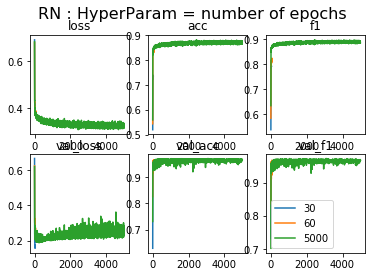

In [6]:
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

leg = [str(i) for i in epochs_range]                                                                                                                                                
                                                                                                                                       
titre = "RN : HyperParam = number of epochs"                                                                                                                                          

plot_perf(ho, leg, titre ,sub_title)

EXPLICATION A REVOIR CAR JE NE VOIS PAS DE SURAPPRENTISSAGE : 
Nous remarquons que les performances (accuracy et f1_score) tendent vers les mêmes taux qu'il y ait 30, 60 ou 120 itérations. 

(graphe time - itérations)

In [ ]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)


Notons ici que le temps d'apprentissage et de prédiction croissent avec le nombre d'itération.

## Question 5
(1 - La démarche de comparaison des hyperparamètres est sérieuse. Les résultats sont présentés de façon correcte et concise dans un tableau et un graphique.
2 - Les explications montrant les différences sont claires, concises et plausibles.
3 - La configuration matérielle sur laquelle les expérimentations est présenteainsi que le temps d’exécution requis pour compléter les expérimentations)

1&2 : (alterner graphe et explication (cf q3) ou mettre tous les graphes (en q3) puis explication ici en q5.

3 : regarder les specs du PC.

In [9]:

X_grid,Y_grid = get_data_GridSearch()
Grid=GridSearch_bestparam(X_grid,Y_grid)



ca commence
best param
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
best score
0.9948977743496463


Analyse Linear


/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
/home/ens/AN03460/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: get_value 

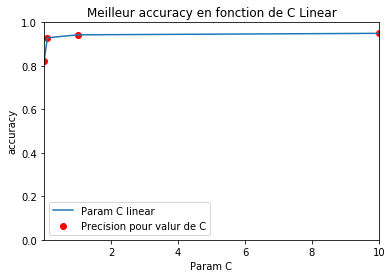

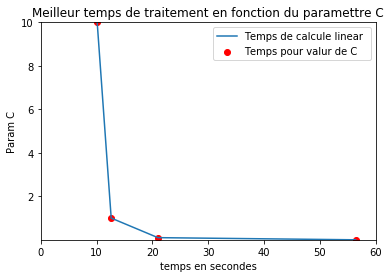

Analyse RBF


/home/ens/AN03460/Desktop/tp3/GTI770-AlexandreBleau_TP3-branch/GTI770_Laboratoire3_-_BLEA14058906_LETD05129708_LIOT20069605/functions.py:241: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  list_accuracy.append(df.get_value(i, 35, 'mean_train_Accuracy'))
/home/ens/AN03460/Desktop/tp3/GTI770-AlexandreBleau_TP3-branch/GTI770_Laboratoire3_-_BLEA14058906_LETD05129708_LIOT20069605/functions.py:242: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  list_time.append(df.get_value(i, 0, 'mean_fit_time'))
/home/ens/AN03460/Desktop/tp3/GTI770-AlexandreBleau_TP3-branch/GTI770_Laboratoire3_-_BLEA14058906_LETD05129708_LIOT20069605/functions.py:243: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  list_Param_C.append(df.get_value(i, 4, 'param_C'))
/home/ens/AN03460/Deskt

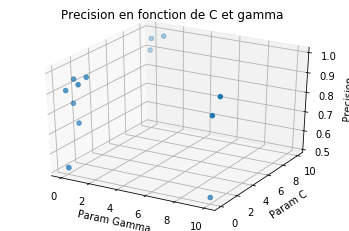

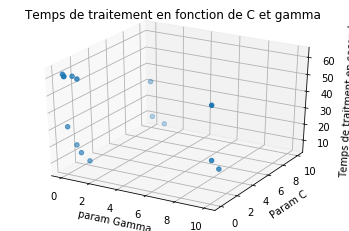

Table de valeur
____________________________________________________________________________________________________
Kernel           Param C   Param Gamma                     Precision Temps de traitement
____________________________________________________________________________________________________
linear             0.001                 nan            0.8214202015467542  56.413630199432376
linear               0.1                 nan            0.9289118037653308  20.981645107269287
linear                 1                 nan            0.9426607296304976  12.610642528533935
linear                10                 nan             0.949535192563081   10.10038890838623
rbf                0.001               0.001            0.5191781892039684   61.78293933868408
rbf                0.001                 0.1            0.5191781892039684   60.65386543273926
rbf                0.001                   1            0.7639246933833295  60.547062969207765
rbf                0.001    

In [26]:
print ('Analyse Linear')

plot_Linear_acc(Grid)

print('Analyse RBF')
plot_RBF_acc(Grid)

print('Table de valeur')
plot_analyse(Grid)
dash= '_'* 100


SVCLine(X_train, Y_train, X_test, Y_test,1)

print('rbf avec meilleur param')
SVC_rbf(X_train, Y_train, X_test, Y_test,10,1)




## Question 6
(1 - La méthode est décrite et un lien avec l’implémentation est fait afin d’expliquer comment l’équipe a trouvé le meilleur modèle SVM. 
2- Les résultats sont présentés de façon correcte et concise dans un TABLEAU ET un GRAPHIQUE. 
3 - La configuration matérielle sur laquelle les expérimentations est présente ainsi que le temps d’exécution requis pour compléter les expérimentations.)

1 - explication implémentation SVM

## Question 7
(L’impact de la taille de l’ensemble d’apprentissage sur les performances est présent et décrit convenablement.)

Dans le cas du MLP, on remarque que pour 1600 images, le temps d'apprentissage se situe autour de 5 secondes. Pour 16000, le temps d'apprentissage est d'environ 32 secondes. 

## Question 8
(Un classificateur est recommandé en se basant sur l’expérimentation précédemment effectuée.)

SVM ou MLP en fonction des résultats (perf + time).

## Question 9
(Des pistes d’amélioration sont proposées.)

Bonne question : investiguer davantages les études d'hyperparamètres pour trouver une solution optimale ?

## Conlusion

(1 - Un court résumé du problème est présent.
2 - Un rappel des résultats est présent.
3 - Des pistes pour de possibles améliorations sont présentes.)

Ce troisième laboratoire nous a permis de comprendre davantage le fonctionnment de deux nouvelles méthodes de classification : SVM et MLP. Dans les deux cas, les temps d'apprentissage sont bien plus long que les premiers laboratoires. 
Avantages et incovénients entre les deux méthodes:
MLP : nb de sorties non limitée != svm => MLP plus évolutif si plus de deux catégories. 

Les résultats sont meilleurs dans le cas de ..... (MLP,SVM ?).

